In [24]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# 1) Paths
DATA_DIR    = Path('/content/drive/MyDrive/Flood_Thesis/Data/static_data')
WEEKLY_CSV  = DATA_DIR / 'datacube_0.1deg_weekly.csv'

# 2) Load weekly tile–week features + frac_flooded
weekly = pd.read_csv(WEEKLY_CSV)

# 3) 0.1° grid: aggregate to annual per tile
ann_fine = weekly.groupby(['year','lat_center','lon_center']).agg({
    'sum_tp':    'sum',   # total yearly precipitation
    'mean_t2m':  'mean',  # average yearly temp
    'mean_slope':'first',
    'dist_to_river_m':'first',
    'frac_flooded':'first'
}).reset_index()

# 4) Split train (2017–2018) / test (2019)
train_f = ann_fine[ann_fine.year.isin([2017,2018])]
test_f  = ann_fine[ann_fine.year == 2019]

Xf_train = train_f[['sum_tp','mean_t2m','mean_slope','dist_to_river_m']]
yf_train = train_f['frac_flooded']
Xf_test  = test_f[['sum_tp','mean_t2m','mean_slope','dist_to_river_m']]
yf_test  = test_f['frac_flooded']

# 5) Train & evaluate RF for 0.1°
rf_f = RandomForestRegressor(n_estimators=200, random_state=42)
rf_f.fit(Xf_train, yf_train)
yf_pred = rf_f.predict(Xf_test)

r2_f = r2_score(yf_test, yf_pred)
rmse_f = np.sqrt(mean_squared_error(yf_test, yf_pred))
print(f"0.1° grid → Test R² = {r2_f:.3f}, RMSE = {rmse_f:.3f}")

# 6) 0.25° grid: bin weekly into coarse tiles & aggregate
weekly['lat025'] = np.where(weekly.lat_center < 27.525, 27.525, 27.775)
weekly['lon025'] = np.where(weekly.lon_center < 85.275, 85.275, 85.525)

ann_coarse = weekly.groupby(['year','lat025','lon025']).agg({
    'sum_tp':    'sum',
    'mean_t2m':  'mean',
    'mean_slope':'first',
    'dist_to_river_m':'first',
    'frac_flooded':'first'
}).reset_index().rename(columns={'lat025':'lat_center','lon025':'lon_center'})

train_c = ann_coarse[ann_coarse.year.isin([2017,2018])]
test_c  = ann_coarse[ann_coarse.year == 2019]

Xc_train = train_c[['sum_tp','mean_t2m','mean_slope','dist_to_river_m']]
yc_train = train_c['frac_flooded']
Xc_test  = test_c[['sum_tp','mean_t2m','mean_slope','dist_to_river_m']]
yc_test  = test_c['frac_flooded']

rf_c = RandomForestRegressor(n_estimators=200, random_state=42)
rf_c.fit(Xc_train, yc_train)
yc_pred = rf_c.predict(Xc_test)

r2_c = r2_score(yc_test, yc_pred)
rmse_c = np.sqrt(mean_squared_error(yc_test, yc_pred))
print(f"0.25° grid → Test R² = {r2_c:.3f}, RMSE = {rmse_c:.3f}")


0.1° grid → Test R² = -140.316, RMSE = 0.219
0.25° grid → Test R² = -139.629, RMSE = 0.225


In [25]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

# ─── 1) Load your weekly tile–week CSV ─────────────────────────────
BASE       = Path('/content/drive/MyDrive/Flood_Thesis/Data/static_data')
weekly     = pd.read_csv(BASE/'datacube_0.1deg_weekly.csv')
TARGET     = 'frac_flooded'

# ─── 2) Aggregate to annual (tile–year) ────────────────────────────
ann = (
    weekly
    .groupby(['year','lat_center','lon_center'])
    .agg({
        'sum_tp':       'sum',
        'mean_t2m':     'mean',
        'mean_swvl1':   'mean',
        'mean_u10':     'mean',
        'mean_v10':     'mean',
        'mean_sp':      'mean',
        'mean_slope':   'first',
        'max_slope':    'first',
        'std_slope':    'first',
        'dist_to_river_m':'first',
        TARGET:         'first'
    })
    .reset_index()
)

# ─── 3) Split train (2017–18) & test (2019) ────────────────────────
train = ann[ann.year.isin([2017,2018])]
test  = ann[ann.year==2019]

X_train = train.drop(columns=['year','lat_center','lon_center',TARGET])
y_train = train[TARGET]
X_test  = test.drop(columns =['year','lat_center','lon_center',TARGET])
y_test  = test[TARGET]

# ─── 4) Hyperparameter Tuning via GridSearchCV ────────────────────
param_grid = {
    'n_estimators':    [100, 300, 500],
    'max_depth':       [None, 5, 10],
    'min_samples_leaf':[1, 3, 5]
}
rf = RandomForestRegressor(random_state=42)

grid = GridSearchCV(
    rf,
    param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best RF params:", grid.best_params_)

best_rf = grid.best_estimator_

# ─── 5) Evaluate on 2019 ──────────────────────────────────────────
y_pred = best_rf.predict(X_test)
r2     = r2_score(y_test, y_pred)
rmse   = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"0.1° grid after tuning → R² = {r2:.3f}, RMSE = {rmse:.3f}")


KeyError: "Column(s) ['mean_sp', 'mean_swvl1', 'mean_u10', 'mean_v10'] do not exist"

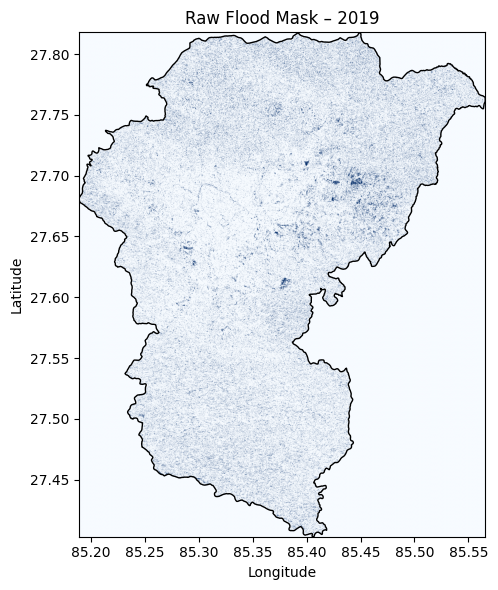

In [5]:
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt

# 1) Paths to your data
shapefile = '/content/drive/MyDrive/Flood_Thesis/Data/kathmandu valley border/kathmandu valley border.shp'
flood_tif = '/content/drive/MyDrive/Flood_Thesis/Data/Flood_labels/flood_label_2019.tif'

# 2) Load the Valley boundary and reproject to the flood TIF's CRS
valley = gpd.read_file(shapefile)
with rasterio.open(flood_tif) as src:
    valley = valley.to_crs(src.crs)
    # 3) Clip the flood raster to the valley polygon
    flooded, transform = mask(src, valley.geometry, crop=True)

# 4) Plot it
fig, ax = plt.subplots(figsize=(6,6))
show(
    flooded[0],          # the first (and only) band: 0/1 mask
    transform=transform, # georeferencing
    ax=ax,
    cmap='Blues'
)
valley.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
ax.set_title("Raw Flood Mask – 2019")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()


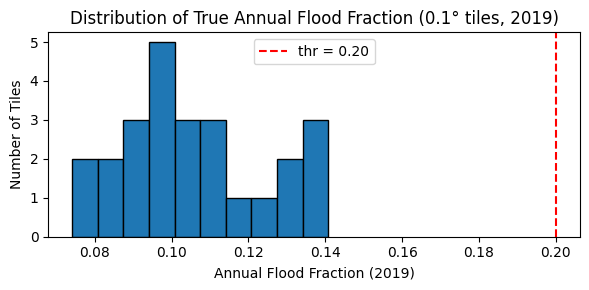

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 1) Load the weekly CSV
WEEKLY_CSV = Path('/content/drive/MyDrive/Flood_Thesis/Data/static_data/datacube_0.1deg_weekly.csv')
weekly     = pd.read_csv(WEEKLY_CSV)

# 2) Compute 2019 annual flood fraction per tile
ann2019 = (
    weekly[weekly.year == 2019]
    .groupby(['lat_center','lon_center'])['frac_flooded']
    .first()
    .reset_index(name='annual_frac')
)

# 3) Plot the histogram
plt.figure(figsize=(6,3))
plt.hist(ann2019['annual_frac'], bins=10, edgecolor='black')
plt.axvline(0.20, color='red', linestyle='--', label='thr = 0.20')
plt.xlabel('Annual Flood Fraction (2019)')
plt.ylabel('Number of Tiles')
plt.title('Distribution of True Annual Flood Fraction (0.1° tiles, 2019)')
plt.legend()
plt.tight_layout()
plt.show()


Loaded weekly data: (3900, 11)
Annual (0.1°) shape: (75, 10)
Threshold = 0.1
Accuracy: 0.520
Confusion Matrix:
 [[ 0 12]
 [ 0 13]]

Classification Report:
               precision    recall  f1-score   support

   Not Flood       0.00      0.00      0.00        12
       Flood       0.52      1.00      0.68        13

    accuracy                           0.52        25
   macro avg       0.26      0.50      0.34        25
weighted avg       0.27      0.52      0.36        25



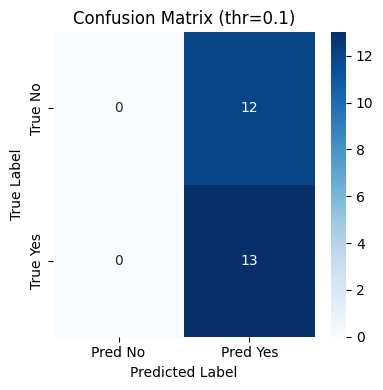

In [22]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# ─── CONFIGURATION ───────────────────────────────────────────────
BASE        = Path('/content/drive/MyDrive/Flood_Thesis/Data/static_data')
WEEKLY_CSV  = BASE / 'datacube_0.1deg_weekly.csv'
THRESHOLD   = 0.1  # any inundation counts as flooded
FEATURES    = ['sum_tp','mean_t2m','mean_slope','max_slope','std_slope','dist_to_river_m']
TARGET      = 'frac_flooded'

# ─── 1) LOAD THE WEEKLY TILE–WEEK DATA ───────────────────────────
weekly = pd.read_csv(WEEKLY_CSV)
print("Loaded weekly data:", weekly.shape)

# ─── 2) AGGREGATE TO ANNUAL (0.1° GRID) ──────────────────────────
ann_fine = (
    weekly
    .groupby(['year','lat_center','lon_center'])
    .agg({
        'sum_tp':           'sum',
        'mean_t2m':         'mean',
        'mean_slope':       'first',
        'max_slope':        'first',
        'std_slope':        'first',
        'dist_to_river_m':  'first',
        TARGET:             'first'
    })
    .reset_index()
)
print("Annual (0.1°) shape:", ann_fine.shape)

# ─── 3) SPLIT TRAIN (2017–18) & TEST (2019) ───────────────────────
train_f = ann_fine[ann_fine.year.isin([2017,2018])]
test_f  = ann_fine[ann_fine.year==2019]
Xf_tr, yf_tr = train_f[FEATURES], train_f[TARGET]
Xf_te, yf_te = test_f[FEATURES],  test_f[TARGET]

# ─── 4) TRAIN & PREDICT ON 0.1° GRID ──────────────────────────────
rf_f = RandomForestRegressor(n_estimators=200, random_state=42)
rf_f.fit(Xf_tr, yf_tr)
yf_pred = rf_f.predict(Xf_te)

# ─── 5) AGGREGATE PREDICTIONS TO ANNUAL BY TILE ──────────────────
# (in this case, one pred per tile-year already since
#  test_f is one row per tile-year)
pred2019 = pd.DataFrame({
    'lat_center': test_f.lat_center,
    'lon_center': test_f.lon_center,
    'pred_frac':  yf_pred
})
ann2019 = test_f[['lat_center','lon_center', TARGET]].rename(columns={TARGET:'annual_true_frac'})

# ─── 6) MERGE TRUE & PREDICTED ANNUAL FRACTIONS ─────────────────
df = ann2019.merge(pred2019, on=['lat_center','lon_center'])

# ─── 7) THRESHOLD AT 0.0 → BINARY LABELS ────────────────────────
df['true_bin'] = (df['annual_true_frac'] > THRESHOLD).astype(int)
df['pred_bin'] = (df['pred_frac']           > THRESHOLD).astype(int)

cm  = confusion_matrix(df['true_bin'], df['pred_bin'], labels=[0,1])
acc = accuracy_score(df['true_bin'], df['pred_bin'])

print(f"Threshold = {THRESHOLD}")
print(f"Accuracy: {acc:.3f}")
print("Confusion Matrix:\n", cm)

# Only print classification_report if both classes are present
if len(np.unique(df['true_bin'])) > 1:
    report = classification_report(
        df['true_bin'], df['pred_bin'],
        labels=[0,1],
        target_names=['Not Flood','Flood'],
        zero_division=0
    )
    print("\nClassification Report:\n", report)
else:
    cls = df['true_bin'].iloc[0]
    cls_name = 'Flood' if cls==1 else 'Not Flood'
    print(f"\nOnly one class present ({cls_name}).  Skipping classification report.")

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred No','Pred Yes'],
            yticklabels=['True No','True Yes'])
plt.title(f"Confusion Matrix (thr={THRESHOLD})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [23]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# yf_te = true annual_frac for 0.1° test set (size 25)
# yf_pred = predicted continuous frac for those same tiles

r2  = r2_score(yf_te, yf_pred)
rmse = np.sqrt(mean_squared_error(yf_te, yf_pred))
print(f"0.1° grid (2019) → R² = {r2:.3f}, RMSE = {rmse:.3f}")


0.1° grid (2019) → R² = -140.768, RMSE = 0.219


In [19]:
# after training rf_c and making yc_pred & yc_te:

r2_c  = r2_score(yc_te, yc_pred)
rmse_c = np.sqrt(mean_squared_error(yc_te, yc_pred))
print(f"0.25° grid (2019) → R² = {r2_c:.3f}, RMSE = {rmse_c:.3f}")


0.25° grid (2019) → R² = -139.880, RMSE = 0.225


In [26]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# ─── 1) File paths ─────────────────────────────────────────────────
BASE           = Path('/content/drive/MyDrive/Flood_Thesis/Data/static_data')
FINE_WK_CSV    = BASE/'datacube_0.1deg_weekly_allvars.csv'
COARSE_WK_CSV  = BASE/'datacube_0.25deg_weekly_allvars.csv'

# ─── 2) Load weekly dataframes ──────────────────────────────────────
df_fine   = pd.read_csv(FINE_WK_CSV)
df_coarse = pd.read_csv(COARSE_WK_CSV)

# ─── 3) Define predictors and target ────────────────────────────────
features = [
    'sum_tp','mean_t2m','mean_swvl1',
    'mean_u10','mean_v10','mean_sp',
    'mean_slope','max_slope','std_slope',
    'dist_to_river_m'
]
target = 'frac_flooded'

# ─── 4) Training & evaluation function ─────────────────────────────
def train_and_eval(df, name):
    # Aggregate weekly → one row per tile & year
    ann = df.groupby(['year','lat_center','lon_center'])[features + [target]].agg({
        'sum_tp': 'sum',           # total precipitation over year
        **{v:'mean' for v in features if v!='sum_tp'},  # average of others
        target: 'first'            # same for each week
    }).reset_index()

    # Split
    train = ann[ann.year.isin([2017,2018])]
    test  = ann[ann.year == 2019]
    X_tr, y_tr = train[features], train[target]
    X_te, y_te = test[features],  test[target]

    # Train
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_tr, y_tr)
    y_pred = rf.predict(X_te)

    # Metrics
    r2   = r2_score(y_te, y_pred)
    rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    print(f"{name} → R² = {r2:.3f}, RMSE = {rmse:.3f}")

# ─── 5) Run for both resolutions ────────────────────────────────────
train_and_eval(df_fine,   "0.1° grid")
train_and_eval(df_coarse, "0.25° grid")


0.1° grid → R² = -104.625, RMSE = 0.189
0.25° grid → R² = -4280.791, RMSE = 0.211


In [27]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# ─── 1) Load the enriched weekly CSV (allvars) ───────────────────
BASE      = Path('/content/drive/MyDrive/Flood_Thesis/Data/static_data')
WK_CSV    = BASE/'datacube_0.1deg_weekly_allvars.csv'
df        = pd.read_csv(WK_CSV)

# ─── 2) Sort & group by tile, then compute lags & rolls ─────────
df = df.sort_values(['lat_center','lon_center','year','week'])

def add_lags_rolls(g):
    g = g.copy()
    g['lag1_tp']   = g['sum_tp'].shift(1).fillna(0)
    g['lag2_tp']   = g['sum_tp'].shift(2).fillna(0)
    g['cum3_tp']   = g['sum_tp'].rolling(3, min_periods=1).sum()
    g['roll2_sw']  = g['mean_swvl1'].rolling(2, min_periods=1).mean()
    return g

df = df.groupby(['lat_center','lon_center']).apply(add_lags_rolls).reset_index(drop=True)

# ─── 3) Define features & target ─────────────────────────────────
base_feats = [
    'sum_tp','mean_t2m','mean_swvl1',
    'mean_u10','mean_v10','mean_sp',
    'mean_slope','max_slope','std_slope','dist_to_river_m'
]
new_feats  = ['lag1_tp','lag2_tp','cum3_tp','roll2_sw']
features   = base_feats + new_feats
target     = 'frac_flooded'

# ─── 4) Aggregate to annual per tile ────────────────────────────
ann = (
    df.groupby(['year','lat_center','lon_center'])[features + [target]]
      .agg({**{'sum_tp':'sum','lag1_tp':'sum','lag2_tp':'sum','cum3_tp':'sum'},
            **{f:'mean' for f in features if f not in ['sum_tp','lag1_tp','lag2_tp','cum3_tp']},
            target:'first'})
      .reset_index()
)

# ─── 5) Split train/test ─────────────────────────────────────────
train = ann[ann.year.isin([2017,2018])]
test  = ann[ann.year==2019]

X_tr, y_tr = train[features], train[target]
X_te, y_te = test[features],  test[target]

# ─── 6) Train & evaluate ────────────────────────────────────────
rf = RandomForestRegressor(n_estimators=300, max_depth=10,
                           min_samples_leaf=3, random_state=42)
rf.fit(X_tr, y_tr)
y_pred = rf.predict(X_te)

r2   = r2_score(y_te, y_pred)
rmse = np.sqrt(mean_squared_error(y_te, y_pred))
print(f"After lags & rolls → R² = {r2:.3f}, RMSE = {rmse:.3f}")


<ipython-input-27-53d692739f77>:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['lat_center','lon_center']).apply(add_lags_rolls).reset_index(drop=True)


After lags & rolls → R² = -109.314, RMSE = 0.193


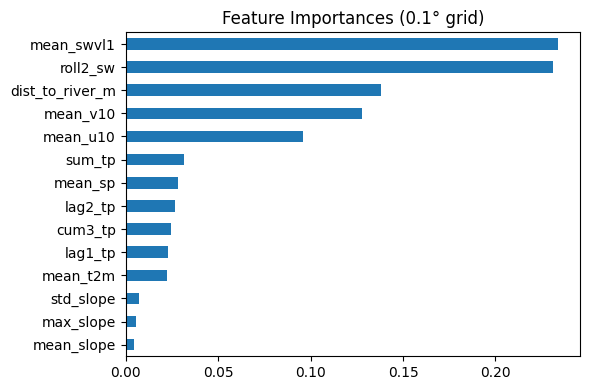

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# assuming `rf` is your trained RandomForestRegressor from above
importances = pd.Series(rf.feature_importances_, index=features)
importances.sort_values().plot.barh(figsize=(6,4))
plt.title("Feature Importances (0.1° grid)")
plt.tight_layout()
plt.show()


In [30]:
import pandas as pd
import numpy as np
from pathlib import Path

# Paths
BASE      = Path('/content/drive/MyDrive/Flood_Thesis/Data/static_data')
WK25_CSV  = BASE/'datacube_0.25deg_weekly_allvars.csv'
WK01_CSV  = BASE/'datacube_0.1deg_weekly_allvars.csv'

def load_and_engineer(path):
    df = pd.read_csv(path).sort_values(
        ['lat_center','lon_center','year','week']
    )
    # lag & rolling
    def eng(g):
        g = g.copy()
        g['lag1_tp']  = g['sum_tp'].shift(1).fillna(0)
        g['lag2_tp']  = g['sum_tp'].shift(2).fillna(0)
        g['cum3_tp']  = g['sum_tp'].rolling(3,1).sum()
        g['roll2_sw'] = g['mean_swvl1'].rolling(2,1).mean()
        # optional monsoon flag
        g['monsoon']  = g.week.between(23,37).astype(int)
        return g
    df = df.groupby(['lat_center','lon_center']).apply(eng).reset_index(drop=True)
    return df

df25 = load_and_engineer(WK25_CSV)
df01 = load_and_engineer(WK01_CSV)


<ipython-input-30-99c4e9c776df>:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['lat_center','lon_center']).apply(eng).reset_index(drop=True)
<ipython-input-30-99c4e9c776df>:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['lat_center','lon_center']).apply(eng).reset_index(drop=True)


In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

features = [
    'sum_tp','mean_t2m','mean_swvl1','mean_u10','mean_v10','mean_sp',
    'mean_slope','max_slope','std_slope','dist_to_river_m',
    'lag1_tp','lag2_tp','cum3_tp','roll2_sw','monsoon'
]
target = 'frac_flooded'

def train_predict(df, label):
    # annual aggregate per tile
    agg = df.groupby(['year','lat_center','lon_center'])[features + [target]].agg(
        {**{'sum_tp':'sum','lag1_tp':'sum','lag2_tp':'sum','cum3_tp':'sum'},
         **{f:'mean' for f in features if f not in ['sum_tp','lag1_tp','lag2_tp','cum3_tp']},
         target:'first'}
    ).reset_index()
    # split
    tr = agg[agg.year.isin([2017,2018])]
    te = agg[agg.year==2019]
    X_tr, y_tr = tr[features], tr[target]
    X_te, y_te = te[features], te[target]
    # fit
    rf = RandomForestRegressor(n_estimators=300, max_depth=10,
                               min_samples_leaf=3, random_state=42)
    rf.fit(X_tr, y_tr)
    y_pred = rf.predict(X_te)
    # metrics
    r2   = r2_score(y_te, y_pred)
    rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    print(f"{label} → R² = {r2:.3f}, RMSE = {rmse:.3f}")
    return rf, X_te, y_te, y_pred

print("=== Coarse 0.25° Grid ===")
rf25, X25_te, y25_te, y25_pred = train_predict(df25, "0.25° grid")
print("\n=== Fine 0.1° Grid ===")
rf01, X01_te, y01_te, y01_pred = train_predict(df01, "0.1° grid")


=== Coarse 0.25° Grid ===
0.25° grid → R² = -4474.570, RMSE = 0.216

=== Fine 0.1° Grid ===
0.1° grid → R² = -109.229, RMSE = 0.193


In [33]:
import pandas as pd
import numpy as np
from pathlib import Path

# Sklearn & XGBoost
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Keras for LSTM
import tensorflow as tf
from tensorflow.keras import layers, models

# ─── 1) Load & engineer ───────────────────────────────────────────
BASE    = Path('/content/drive/MyDrive/Flood_Thesis/Data/static_data')
CSV01   = BASE/'datacube_0.1deg_weekly_allvars.csv'
df      = pd.read_csv(CSV01).sort_values(['lat_center','lon_center','year','week'])

def eng(g):
    g = g.copy()
    g['lag1_tp']  = g['sum_tp'].shift(1).fillna(0)
    g['lag2_tp']  = g['sum_tp'].shift(2).fillna(0)
    g['cum3_tp']  = g['sum_tp'].rolling(3,1).sum()
    g['roll2_sw'] = g['mean_swvl1'].rolling(2,1).mean()
    g['monsoon']  = g.week.between(23,37).astype(int)
    return g

df = df.groupby(['lat_center','lon_center']).apply(eng).reset_index(drop=True)

# ─── 2) Annual aggregation ────────────────────────────────────────
features = [
    'sum_tp','mean_t2m','mean_swvl1','mean_u10','mean_v10','mean_sp',
    'mean_slope','max_slope','std_slope','dist_to_river_m',
    'lag1_tp','lag2_tp','cum3_tp','roll2_sw','monsoon'
]
target = 'frac_flooded'

agg = df.groupby(['year','lat_center','lon_center'])[features + [target]].agg({
    **{'sum_tp':'sum','lag1_tp':'sum','lag2_tp':'sum','cum3_tp':'sum'},
    **{f:'mean' for f in features if f not in ['sum_tp','lag1_tp','lag2_tp','cum3_tp']},
    target:'first'
}).reset_index()

train = agg[agg.year.isin([2017,2018])]
test  = agg[agg.year==2019]
X_tr, y_tr = train[features], train[target]
X_te, y_te = test[features],  test[target]

# ─── 3) Linear Regression ─────────────────────────────────────────
lr = LinearRegression()
lr.fit(X_tr, y_tr)
y_lr = lr.predict(X_te)
r2_lr  = r2_score(y_te, y_lr)
rmse_lr = np.sqrt(mean_squared_error(y_te, y_lr))

# ─── 4) Random Forest ─────────────────────────────────────────────
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_tr, y_tr)
y_rf = rf.predict(X_te)
r2_rf  = r2_score(y_te, y_rf)
rmse_rf = np.sqrt(mean_squared_error(y_te, y_rf))

# ─── 5) XGBoost ──────────────────────────────────────────────────
xgb = XGBRegressor(n_estimators=200, random_state=42, tree_method='hist')
xgb.fit(X_tr, y_tr)
y_xgb = xgb.predict(X_te)
r2_xgb  = r2_score(y_te, y_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_te, y_xgb))

# ─── 6) LSTM ──────────────────────────────────────────────────────
# Prepare 3D input: [samples, timesteps, features] using weekly as timesteps
# Here we simply treat each tile as one “sequence” of 52 weeks per year.
# We'll stack the 2017–18 train sequences and predict 2019 as a sequence
def seqify(df, years):
    seqs, ys = [], []
    for tile, grp in df[df.year.isin(years)].groupby(['lat_center','lon_center']):
        arr = grp.sort_values('week')[features].to_numpy()
        seqs.append(arr)
        ys.append(grp[target].mean())   # average annual frac
    return np.stack(seqs), np.array(ys)

# train on 2017+2018 sequences, test on 2019
X_seq_tr, y_seq_tr = seqify(df, [2017,2018])
X_seq_te, y_seq_te = seqify(df, [2019])

model = models.Sequential([
    layers.Input((X_seq_tr.shape[1], X_seq_tr.shape[2])),
    layers.LSTM(32, activation='tanh'),
    layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_seq_tr, y_seq_tr, epochs=50, batch_size=8, verbose=0)
y_lstm = model.predict(X_seq_te).flatten()
r2_lstm  = r2_score(y_seq_te, y_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_seq_te, y_lstm))

# ─── 7) Report all metrics ────────────────────────────────────────
results = pd.DataFrame({
    'Model':    ['LinearReg','RandomForest','XGBoost','LSTM'],
    'R2':       [r2_lr, r2_rf, r2_xgb, r2_lstm],
    'RMSE':     [rmse_lr, rmse_rf, rmse_xgb, rmse_lstm]
})
print(results.to_string(index=False))


<ipython-input-33-1e380948bdae>:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['lat_center','lon_center']).apply(eng).reset_index(drop=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
       Model          R2     RMSE
   LinearReg -125.232861 0.206557
RandomForest -107.697845 0.191675
     XGBoost  -95.933639 0.181006
        LSTM  -34.482470 0.109512


<ipython-input-34-9ef1a727b8a2>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(models, rotation=45, ha='right')
<ipython-input-34-9ef1a727b8a2>:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(models, rotation=45, ha='right')


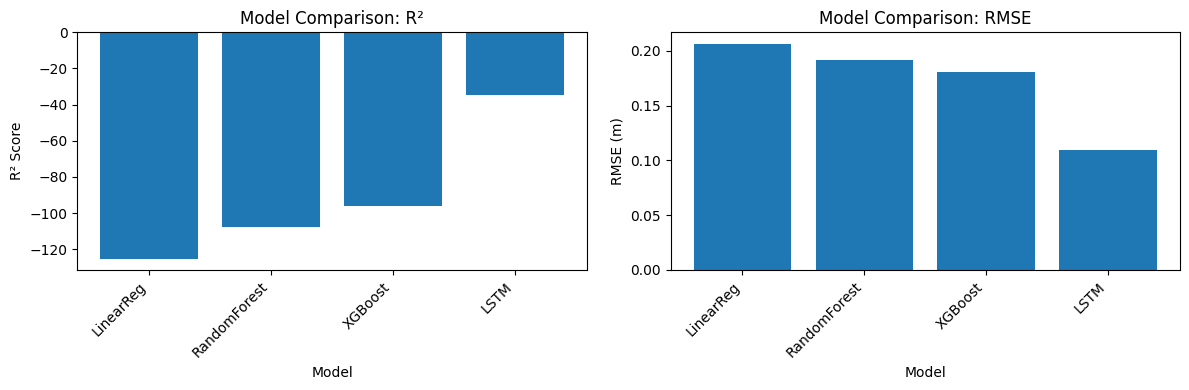

In [34]:
import matplotlib.pyplot as plt

# Model names and metrics
models = ['LinearReg', 'RandomForest', 'XGBoost', 'LSTM']
r2_scores = [-125.232861, -107.697845, -95.933639, -34.482470]
rmse_scores = [0.206557, 0.191675, 0.181006, 0.109512]

# Create side-by-side bar charts
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# R² bar chart
axes[0].bar(models, r2_scores)
axes[0].set_title('Model Comparison: R²')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('R² Score')
axes[0].set_xticklabels(models, rotation=45, ha='right')

# RMSE bar chart
axes[1].bar(models, rmse_scores)
axes[1].set_title('Model Comparison: RMSE')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('RMSE (m)')
axes[1].set_xticklabels(models, rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [37]:
import pandas as pd
import numpy as np
from pathlib import Path
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models

# ─── 1) Load & engineer your weekly data (as before) ─────────────
BASE   = Path('/content/drive/MyDrive/Flood_Thesis/Data/static_data')
CSV01  = BASE/'datacube_0.1deg_weekly_allvars.csv'
df     = pd.read_csv(CSV01).sort_values(['lat_center','lon_center','year','week'])

def engineer(g):
    g = g.copy()
    g['lag1_tp']  = g['sum_tp'].shift(1).fillna(0)
    g['lag2_tp']  = g['sum_tp'].shift(2).fillna(0)
    g['cum3_tp']  = g['sum_tp'].rolling(3,1).sum()
    g['roll2_sw'] = g['mean_swvl1'].rolling(2,1).mean()
    g['monsoon']  = g.week.between(23,37).astype(int)
    return g

df = df.groupby(['lat_center','lon_center']).apply(engineer).reset_index(drop=True)

features = [
    'sum_tp','mean_t2m','mean_swvl1','mean_u10','mean_v10','mean_sp',
    'mean_slope','max_slope','std_slope','dist_to_river_m',
    'lag1_tp','lag2_tp','cum3_tp','roll2_sw','monsoon'
]
target = 'frac_flooded'

# Build sequences per tile
def make_seq(df, years):
    X, y = [], []
    for _, grp in df[df.year.isin(years)].groupby(['lat_center','lon_center']):
        arr = grp.sort_values('week')[features].to_numpy()
        X.append(arr)
        y.append(grp[target].iloc[0])
    return np.stack(X), np.array(y)

X_all, y_all = make_seq(df, [2017,2018])
X_test, y_test = make_seq(df, [2019])

# Split 2017–18 into train/val
X_tr, X_val, y_tr, y_val = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

# Scale features
ns, nt, nf = X_tr.shape
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr.reshape(-1,nf)).reshape(ns,nt,nf)
X_val = scaler.transform(X_val.reshape(-1,nf)).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1,nf)).reshape(X_test.shape)

# ─── 2) Random search over hyperparameters ─────────────────────────
param_space = {
    'units':    [32, 64, 128],
    'dropout':  [0.1, 0.3, 0.5],
    'lr':       [1e-4, 1e-3, 1e-2],
    'batch':    [8, 16, 32]
}

best_val_r2 = -np.inf
best_params = None
best_model  = None

for _ in range(10):
    # pick random combo
    params = {k: random.choice(v) for k,v in param_space.items()}
    # build model
    inp = layers.Input(shape=(nt, nf))
    x = layers.LSTM(params['units'])(inp)
    x = layers.Dropout(params['dropout'])(x)
    out = layers.Dense(1)(x)
    m = models.Model(inp, out)
    m.compile(optimizer=tf.keras.optimizers.Adam(params['lr']), loss='mse')
    # train
    m.fit(X_tr, y_tr,
          validation_data=(X_val,y_val),
          epochs=30, batch_size=params['batch'],
          verbose=0)
    # eval
    y_val_pred = m.predict(X_val).flatten()
    r2_val = r2_score(y_val, y_val_pred)
    if r2_val > best_val_r2:
        best_val_r2 = r2_val
        best_params  = params
        best_model   = m

print("Best validation R²:", best_val_r2)
print("Best params:", best_params)

# ─── 3) Re-train on full 2017–18 and test on 2019 ────────────────
# combine X_tr+X_val into full train
X_full = np.concatenate([X_tr, X_val], axis=0)
y_full = np.concatenate([y_tr, y_val], axis=0)
best_model.compile(optimizer=tf.keras.optimizers.Adam(best_params['lr']),
                   loss='mse')
best_model.fit(X_full, y_full,
               epochs=30, batch_size=best_params['batch'],
               verbose=0)

# test
y_test_pred = best_model.predict(X_test).flatten()
r2_test  = r2_score(y_test, y_test_pred)
rmse_test= np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Tuned LSTM on 2019 → R² = {r2_test:.3f}, RMSE = {rmse_test:.3f}")


<ipython-input-37-4b17e18b51ac>:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['lat_center','lon_center']).apply(engineer).reset_index(drop=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
Best validation R²: -0.8099897516089709
Best params: {'units': 64, 'dropout': 0.5, 'lr': 0.01, 'batch': 32}


ValueError: Input 0 of layer "functional_2" is incompatible with the layer: expected shape=(None, 104, 15), found shape=(25, 52, 15)

In [39]:
import pandas as pd
import numpy as np
from pathlib import Path
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers, models

# 1) Load & engineer your weekly data
BASE   = Path('/content/drive/MyDrive/Flood_Thesis/Data/static_data')
CSV01  = BASE/'datacube_0.1deg_weekly_allvars.csv'
df     = pd.read_csv(CSV01).sort_values(['lat_center','lon_center','year','week'])

def engineer(g):
    g = g.copy()
    g['lag1_tp']  = g['sum_tp'].shift(1).fillna(0)
    g['lag2_tp']  = g['sum_tp'].shift(2).fillna(0)
    g['cum3_tp']  = g['sum_tp'].rolling(3,1).sum()
    g['roll2_sw'] = g['mean_swvl1'].rolling(2,1).mean()
    g['monsoon']  = g.week.between(23,37).astype(int)
    return g

# use group_keys=False to keep year in the DataFrame columns and not as index
df = df.groupby(
    ['lat_center','lon_center','year'],
    group_keys=False
).apply(engineer).reset_index(drop=True)

# 2) Build sequences per tile‐year
def make_seq(df, years):
    X, y = [], []
    for (yr, lat, lon), grp in df[df.year.isin(years)].groupby(
            ['year','lat_center','lon_center']):
        arr = grp.sort_values('week')[features].to_numpy()  # shape (52,feat)
        X.append(arr)
        y.append(grp[target].iloc[0])
    return np.stack(X), np.array(y)

# Now this will correctly give X_all.shape = (50, 52, 15) and X_test = (25,52,15)
X_all, y_all = make_seq(df, [2017,2018])
X_test, y_test = make_seq(df, [2019])


# 3) Train/validation split of the 50 training sequences
X_tr, X_val, y_tr, y_val = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

# 4) Standardize features (flatten then reshape)
ns, nt, nf = X_tr.shape
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr.reshape(-1, nf)).reshape(ns, nt, nf)
X_val = scaler.transform(X_val.reshape(-1, nf)).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1, nf)).reshape(X_test.shape)

# 5) Manual random search over hyperparameters
param_space = {
    'units':    [32, 64, 128],
    'dropout':  [0.1, 0.3, 0.5],
    'lr':       [1e-4, 1e-3, 1e-2],
    'batch':    [8, 16, 32]
}

best_val_r2 = -np.inf
best_params = None
best_model  = None

for _ in range(10):
    params = {k: random.choice(v) for k,v in param_space.items()}
    # build model
    inp = layers.Input(shape=(nt, nf))
    x = layers.LSTM(params['units'])(inp)
    x = layers.Dropout(params['dropout'])(x)
    out = layers.Dense(1)(x)
    m = models.Model(inp, out)
    m.compile(optimizer=tf.keras.optimizers.Adam(params['lr']), loss='mse')
    # train with early stopping
    m.fit(X_tr, y_tr,
          validation_data=(X_val,y_val),
          epochs=30, batch_size=params['batch'],
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
          verbose=0)
    # evaluate
    y_val_pred = m.predict(X_val).flatten()
    r2_val = r2_score(y_val, y_val_pred)
    if r2_val > best_val_r2:
        best_val_r2 = r2_val
        best_params  = params
        best_model   = m

print("Best validation R²:", best_val_r2)
print("Best params:", best_params)

# 6) Re-train best model on full 2017-18 data
X_full = np.concatenate([X_tr, X_val], axis=0)
y_full = np.concatenate([y_tr, y_val], axis=0)
best_model.compile(optimizer=tf.keras.optimizers.Adam(best_params['lr']), loss='mse')
best_model.fit(X_full, y_full,
               epochs=30, batch_size=best_params['batch'],
               verbose=0)

# 7) Final evaluation on 2019
y_test_pred = best_model.predict(X_test).flatten()
r2_test  = r2_score(y_test, y_test_pred)
rmse_test= np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Tuned LSTM on 2019 → R² = {r2_test:.3f}, RMSE = {rmse_test:.3f}")


<ipython-input-39-fade7e3145c0>:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(engineer).reset_index(drop=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Best validation R²: 0.22082468280170953
Best params: {'units': 128, 'dropout': 0.3, 'lr': 0.001, 'batch': 16}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Tuned LSTM on 2019 → R² = -81.254, RMSE = 0.167


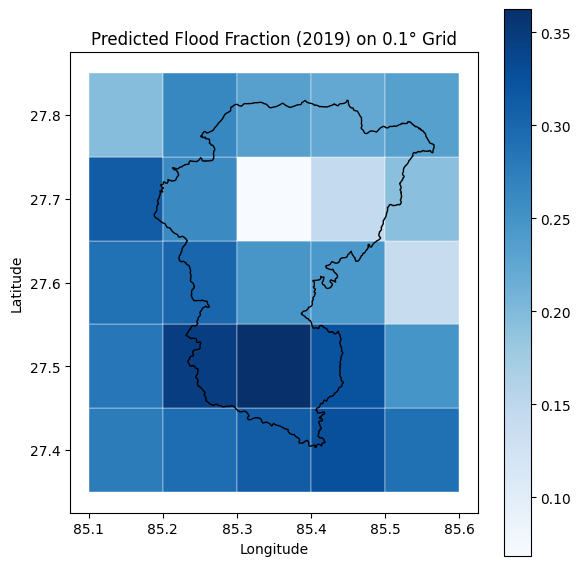

NameError: name 'y25_test_pred' is not defined

In [40]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import box
from pathlib import Path

# ─── 1) Load your shapefile ───────────────────────────────────────────
shp = gpd.read_file(
    '/content/drive/MyDrive/Flood_Thesis/Data/kathmandu valley border/kathmandu valley border.shp'
).to_crs(epsg=4326)

# ─── 2) Prepare prediction DataFrame for 0.1° grid ───────────────────
# Assume you’ve run the tuned LSTM and have:
#   X_test, y_test_pred  (arrays of shape [n_tiles, 52, n_feats])
#   test_index           (list of (year, lat_center, lon_center) tuples for 2019)
# Here’s how to assemble a GeoDataFrame:

# Example: reconstruct test_index when you created X_test
test_index = []
for (yr, lat, lon), grp in df[df.year==2019].groupby(['year','lat_center','lon_center']):
    test_index.append((lat, lon))

# Flatten predictions to one per tile-year
preds_01 = pd.DataFrame(test_index, columns=['lat_center','lon_center'])
preds_01['pred_frac'] = y_test_pred  # your tuned-LSTM output

# Build 0.1° tile boxes
HALF01 = 0.05
preds_01['geometry'] = preds_01.apply(
    lambda r: box(r.lon_center-HALF01,
                  r.lat_center-HALF01,
                  r.lon_center+HALF01,
                  r.lat_center+HALF01),
    axis=1
)
gdf_pred_01 = gpd.GeoDataFrame(preds_01, crs='EPSG:4326')

# ─── 3) Plot the fine grid predictions ───────────────────────────────
fig, ax = plt.subplots(figsize=(6,6))
gdf_pred_01.plot(
    column='pred_frac',
    ax=ax,
    cmap='Blues',
    legend=True,
    edgecolor='white',
    linewidth=0.3
)
shp.boundary.plot(ax=ax, color='black', linewidth=1)
ax.set_title("Predicted Flood Fraction (2019) on 0.1° Grid")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()


# ─── 4) Repeat for 0.25° grid ────────────────────────────────────────
# Assuming you also have `y25_test_pred` and `test25_index` analogously
# Example:
test25_index = []
for (yr, lat, lon), grp in df25[df25.year==2019].groupby(['year','lat_center','lon_center']):
    test25_index.append((lat, lon))

preds_25 = pd.DataFrame(test25_index, columns=['lat_center','lon_center'])
preds_25['pred_frac'] = y25_test_pred

HALF25 = 0.125
preds_25['geometry'] = preds_25.apply(
    lambda r: box(r.lon_center-HALF25,
                  r.lat_center-HALF25,
                  r.lon_center+HALF25,
                  r.lat_center+HALF25),
    axis=1
)
gdf_pred_25 = gpd.GeoDataFrame(preds_25, crs='EPSG:4326')

fig, ax = plt.subplots(figsize=(6,6))
gdf_pred_25.plot(
    column='pred_frac',
    ax=ax,
    cmap='Blues',
    legend=True,
    edgecolor='white',
    linewidth=0.5
)
shp.boundary.plot(ax=ax, color='black', linewidth=1)
ax.set_title("Predicted Flood Fraction (2019) on 0.25° Grid")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()
